In [499]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob

from wordcloud import WordCloud, STOPWORDS
import string
from nltk import tokenize, wordnet
import transformers
import tqdm

from sklearn.feature_selection import mutual_info_classif, SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline

In [500]:
train = pd.read_csv("./dataset/dreaddit-train.csv")
test = pd.read_csv("./dataset/dreaddit-test.csv")

In [501]:
print(train.head(), train.shape)

          subreddit post_id sentence_range  \
0              ptsd  8601tu       (15, 20)   
1        assistance  8lbrx9         (0, 5)   
2              ptsd  9ch1zh       (15, 20)   
3     relationships  7rorpp        [5, 10]   
4  survivorsofabuse  9p2gbc         [0, 5]   

                                                text     id  label  \
0  He said he had not felt that way before, sugge...  33181      1   
1  Hey there r/assistance, Not sure if this is th...   2606      0   
2  My mom then hit me with the newspaper and it s...  38816      1   
3  until i met my new boyfriend, he is amazing, h...    239      1   
4  October is Domestic Violence Awareness Month a...   1421      1   

   confidence  social_timestamp  social_karma  syntax_ari  ...  \
0         0.8        1521614353             5    1.806818  ...   
1         1.0        1527009817             4    9.429737  ...   
2         0.8        1535935605             2    7.769821  ...   
3         0.6        1516429555       

In [502]:
print(test.head(), test.shape)

      id      subreddit post_id sentence_range  \
0    896  relationships  7nu7as       [50, 55]   
1  19059        anxiety  680i6d        (5, 10)   
2   7977           ptsd  8eeu1t        (5, 10)   
3   1214           ptsd  8d28vu         [2, 7]   
4   1965  relationships  7r1e85       [23, 28]   

                                                text  label  confidence  \
0  Its like that, if you want or not.“ ME: I have...      0         0.8   
1  I man the front desk and my title is HR Custom...      0         1.0   
2  We'd be saving so much money with this new hou...      1         1.0   
3  My ex used to shoot back with "Do you want me ...      1         0.5   
4  I haven’t said anything to him yet because I’m...      0         0.8   

   social_timestamp  social_karma  syntax_ari  ...  lex_dal_min_pleasantness  \
0      1.514981e+09            22   -1.238793  ...                    1.0000   
1      1.493348e+09             5    7.684583  ...                    1.4000   
2      1

## TextBlob
* Polarity: float value within -1 to 1. 0: neutral, +1: very positive, -1: very negative
* Subjectivity: float value within 0 to 1. 0: very objective, 1: very subjective

In [503]:
print("Sentiment : ",TextBlob("I feel like nothing will ever get better and there's no point in even trying.").sentiment)

Sentiment :  Sentiment(polarity=0.5, subjectivity=0.5)


In [504]:
print(train.text[0])

He said he had not felt that way before, suggeted I go rest and so ..TRIGGER AHEAD IF YOUI'RE A HYPOCONDRIAC LIKE ME: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something I could even laugh at down the road. No, I ended up reading that this sense of doom can be indicative of various health ailments; one of which I am prone to.. So on top of my "doom" to my gloom..I am now f'n worried about my heart. I do happen to have a physical in 48 hours.


In [505]:
reddits = pd.DataFrame()
reddits['text'] = train.text
reddits['sentiment_generated'] = reddits['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
reddits['label'] = train.label
reddits.head()

,text,sentiment_generated,label
0,"He said he had not felt that way before, sugge...",-0.002742,1
1,"Hey there r/assistance, Not sure if this is th...",0.292857,0
2,My mom then hit me with the newspaper and it s...,0.011894,1
3,"until i met my new boyfriend, he is amazing, h...",0.141671,1
4,October is Domestic Violence Awareness Month a...,-0.204167,1


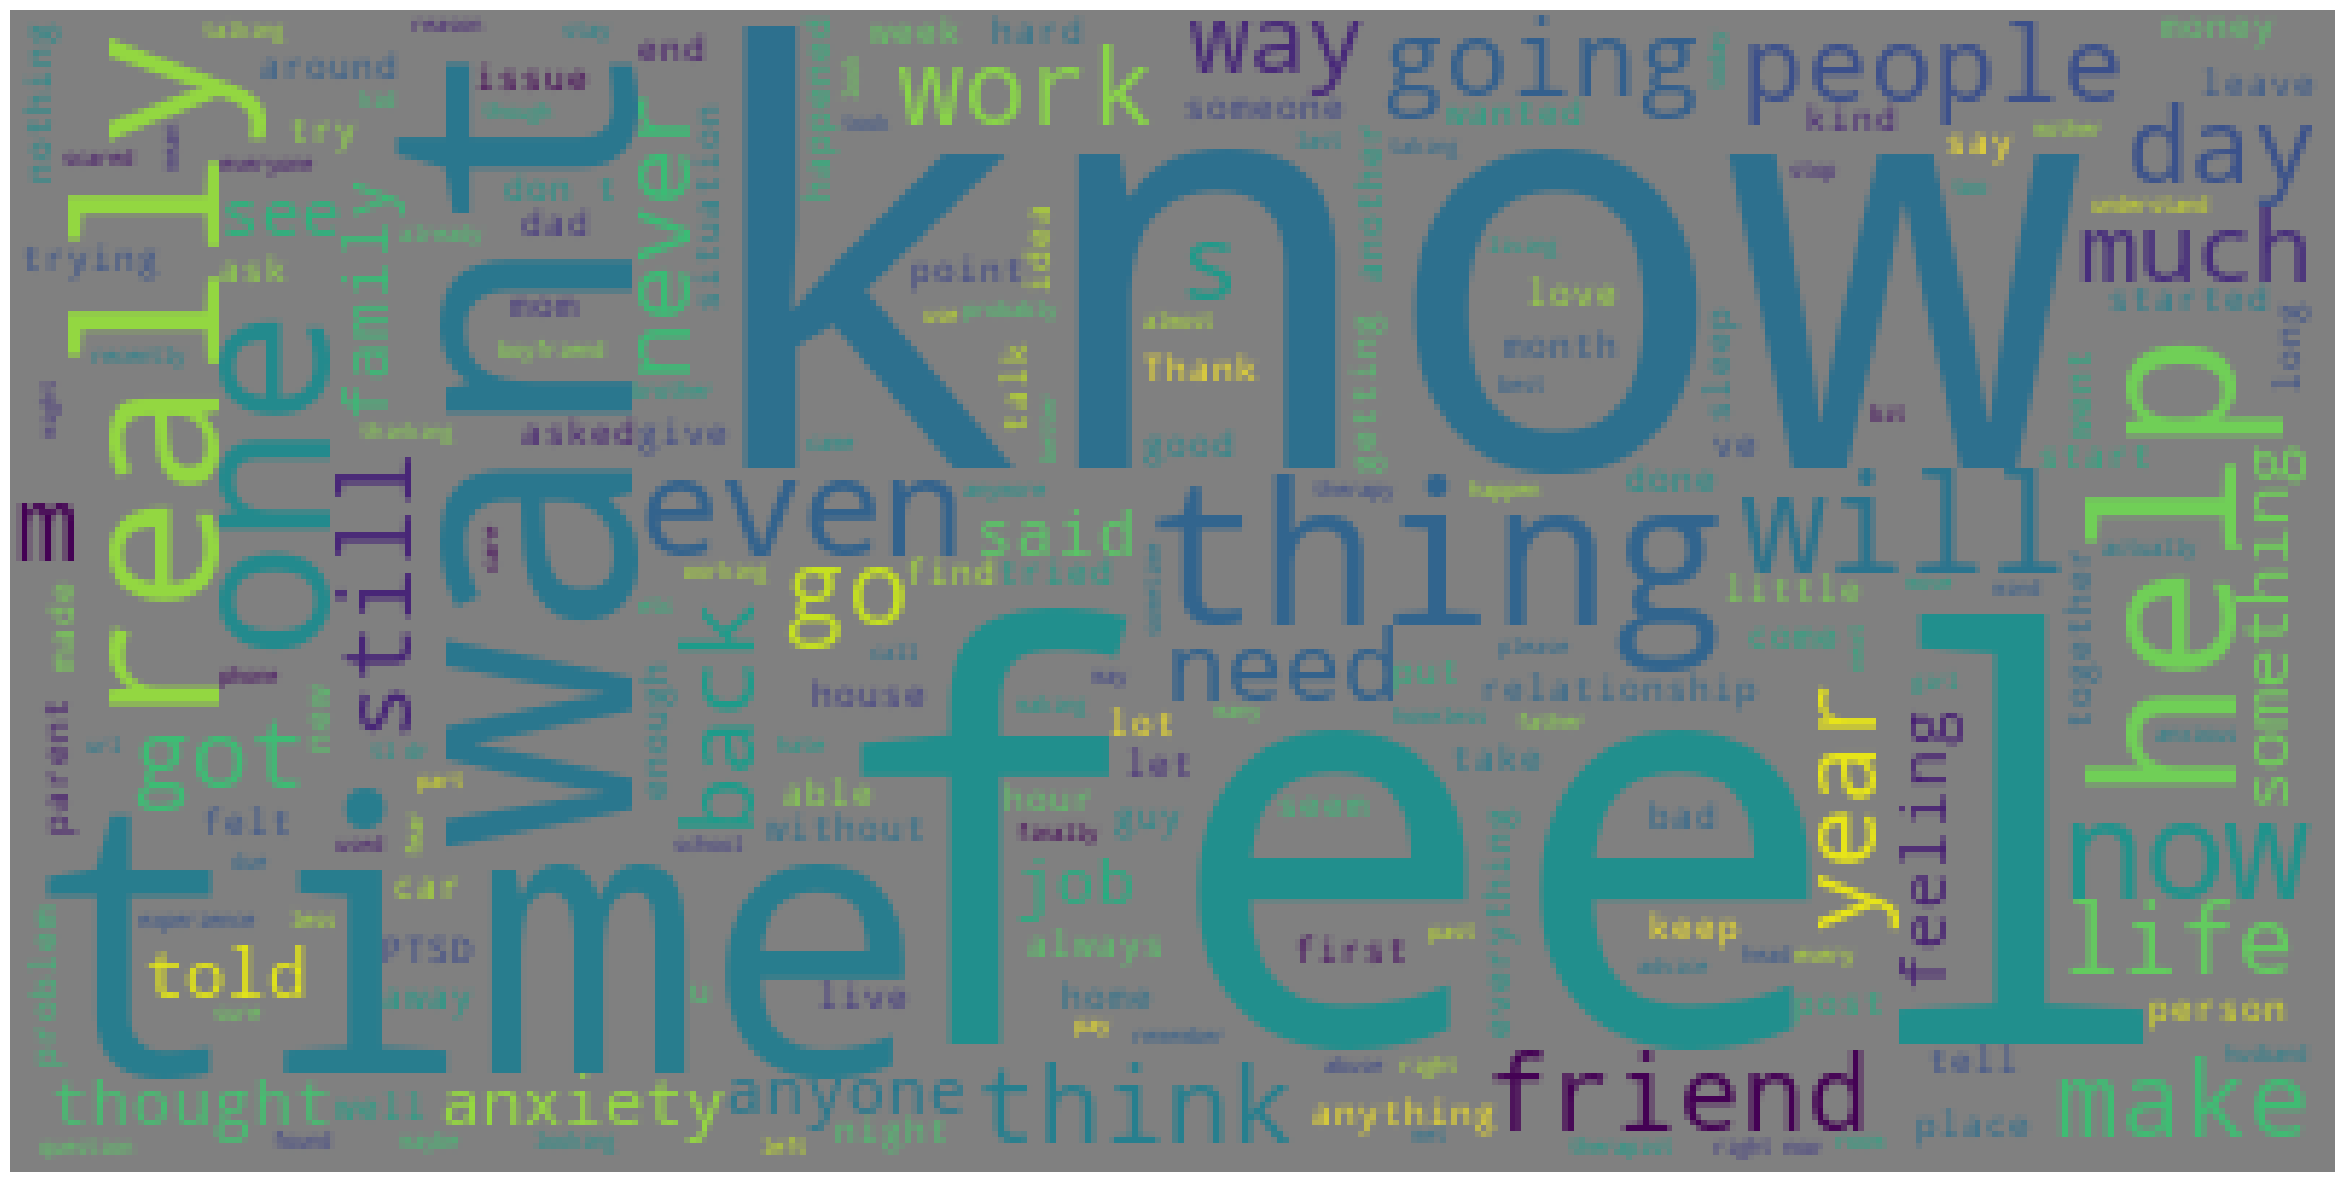

In [506]:
# todo generate subplot for first 9 reddit
def wc(data,bgcolor):
    plt.figure(figsize=(30,30))
    wc=WordCloud(background_color=bgcolor,stopwords=STOPWORDS)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis("off")
wc(reddits.text,'grey')

In [507]:
status = "status"
reddits[status] = reddits["label"].map({0:"Unstressed", 1:"Stressed"})
reddits.head()

,text,sentiment_generated,label,status
0,"He said he had not felt that way before, sugge...",-0.002742,1,Stressed
1,"Hey there r/assistance, Not sure if this is th...",0.292857,0,Unstressed
2,My mom then hit me with the newspaper and it s...,0.011894,1,Stressed
3,"until i met my new boyfriend, he is amazing, h...",0.141671,1,Stressed
4,October is Domestic Violence Awareness Month a...,-0.204167,1,Stressed


<AxesSubplot: xlabel='status', ylabel='count'>

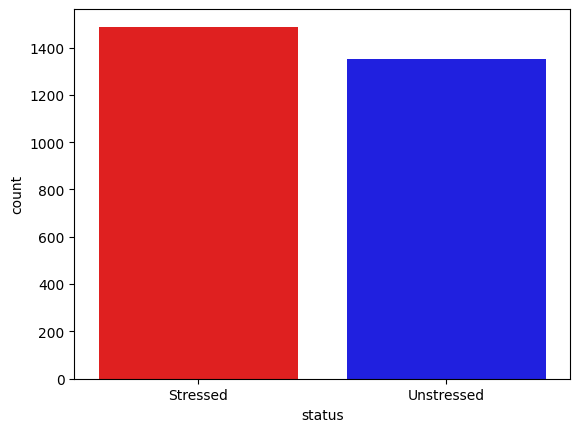

In [508]:
sns.countplot(x=status, data = reddits, palette= ["#ff0000", "#0000ff"])

# Data Cleaning Process
1. Tokenization
2. Lemmatizing
3. Stopword, punctuation Removal

In [509]:
# tokenize
reddits['tokenized_text'] = reddits['text'].apply(lambda x: tokenize.word_tokenize(x, preserve_line=True))

# lemmatize
lemmatizer = wordnet.WordNetLemmatizer()
def lemmatize_text(sentence):
    return " ".join(lemmatizer.lemmatize(word)for word in sentence)
reddits['lemmatized_text'] = reddits['tokenized_text'].apply(lemmatize_text)

# stopwords removal
def lower(text):
    return text.lower()

def remove_stopwords(text):
    stopwords = list(STOPWORDS)
    return " ".join([word for word in str(text).split() if word not in stopwords])

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_multiple_space(text):
    text = text.replace("   ", " ")
    return text.replace("  ", " ")

def clean_text(text):
    text = lower(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    text = remove_multiple_space(text)

    return text
reddits['cleaned_text']=reddits['lemmatized_text'].apply(clean_text)
reddits

,text,sentiment_generated,label,status,tokenized_text,lemmatized_text,cleaned_text
0,"He said he had not felt that way before, sugge...",-0.002742,1,Stressed,"[He, said, he, had, not, felt, that, way, befo...","He said he had not felt that way before , sugg...",said felt way suggeted go rest trigger ahead y...
1,"Hey there r/assistance, Not sure if this is th...",0.292857,0,Unstressed,"[Hey, there, r/assistance, ,, Not, sure, if, t...","Hey there r/assistance , Not sure if this is t...",hey rassistance sure right place post go m cur...
2,My mom then hit me with the newspaper and it s...,0.011894,1,Stressed,"[My, mom, then, hit, me, with, the, newspaper,...",My mom then hit me with the newspaper and it s...,mom hit newspaper shocked know nt play hitting...
3,"until i met my new boyfriend, he is amazing, h...",0.141671,1,Stressed,"[until, i, met, my, new, boyfriend, ,, he, is,...","until i met my new boyfriend , he is amazing ,...",met new boyfriend amazing kind sweet good stud...
4,October is Domestic Violence Awareness Month a...,-0.204167,1,Stressed,"[October, is, Domestic, Violence, Awareness, M...",October is Domestic Violence Awareness Month a...,october domestic violence awareness month dome...
...,...,...,...,...,...,...,...
2833,"* Her, a week ago: Precious, how are you? (I i...",0.552066,0,Unstressed,"[*, Her, ,, a, week, ago, :, Precious, ,, how,...","* Her , a week ago : Precious , how are you ? ...",week ago precious ignored her jan 1 happy yea...
2834,I don't have the ability to cope with it anymo...,-0.220370,1,Stressed,"[I, do, n't, have, the, ability, to, cope, wit...",I do n't have the ability to cope with it anym...,nt ability cope anymore m trying lot thing tri...
2835,In case this is the first time you're reading ...,0.045455,0,Unstressed,"[In, case, this, is, the, first, time, you, 'r...",In case this is the first time you 're reading...,case first time re reading post looking people...
2836,Do you find this normal? They have a good rela...,0.159722,0,Unstressed,"[Do, you, find, this, normal, ?, They, have, a...",Do you find this normal ? They have a good rel...,find normal good relationship main problem wil...


## BERT Paper
https://arxiv.org/abs/1810.04805

In [510]:
# -START--------- this part just for testing another method -------------
# import tensorflow_hub as hub
# import tensorflow_text as text
# import tensorflow as tf

In [511]:
# bert_preprocess_model = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

In [512]:
# bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [513]:
# def get_sentence_embeding(sentences):
#     preprocessed_text = bert_preprocess_model(sentences)
#     return bert_encoder(preprocessed_text)['pooled_output']

In [514]:
# subreddit = get_sentence_embeding(train["subreddit"])
# embeded_text = get_sentence_embeding(train["text"])

In [515]:
# -END--------- this part just for testing another method -------------

In [516]:
def func_tokenizer(tokenizer_name, docs):
    features = []
    for doc in tqdm.tqdm(docs, desc = 'converting documents to features'):
        tokens = tokenizer_name.tokenize(doc)
        ids = tokenizer_name.convert_tokens_to_ids(tokens)
        features.append(ids)
    return features

In [517]:

bert_tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')
bert_features_text = func_tokenizer(bert_tokenizer, reddits['cleaned_text'])

converting documents to features: 100%|██████████| 2838/2838 [00:01<00:00, 2024.34it/s]


In [518]:
df = train.copy().drop(columns=["post_id", "id", "sentence_range", "label", "text", "subreddit"])
y = train["label"]
df.shape

(2838, 110)

In [519]:
# feature selection
selector = SelectPercentile(mutual_info_classif, percentile=25).fit(df, y)
mask = selector.get_support()
df_reduced = df[df.columns[mask]]
print(df_reduced.shape, df_reduced)

(2838, 28)       confidence  social_timestamp  lex_liwc_Analytic  lex_liwc_Clout  \
0       0.800000        1521614353              72.64           15.04   
1       1.000000        1527009817              79.08           76.85   
2       0.800000        1535935605              33.80           76.38   
3       0.600000        1516429555               2.98           15.25   
4       0.800000        1539809005              32.22           28.71   
...          ...               ...                ...             ...   
2833    1.000000        1515187044              19.41           99.00   
2834    1.000000        1539827412              40.97            4.45   
2835    1.000000        1539269312              79.52           97.34   
2836    0.571429        1488938143              29.74           61.58   
2837    0.571429        1488909516               1.00           29.92   

      lex_liwc_Authentic  lex_liwc_Tone  lex_liwc_Dic  lex_liwc_function  \
0                  89.26           1

In [520]:
standard = StandardScaler()
df_standard = pd.DataFrame(standard.fit_transform(df_reduced), columns = df_reduced.columns)
print(df_standard, "\n", df_standard.shape)

      confidence  social_timestamp  lex_liwc_Analytic  lex_liwc_Clout  \
0      -0.050686          0.225997           1.412270       -0.820360   
1       1.079212          0.573657           1.655458        1.136796   
2      -0.050686          1.148796          -0.054413        1.121913   
3      -1.180584         -0.108089          -1.218243       -0.813710   
4      -0.050686          1.398381          -0.114077       -0.387512   
...          ...               ...                ...             ...   
2833    1.079212         -0.188151          -0.597811        1.838154   
2834    1.079212          1.399567           0.216342       -1.155682   
2835    1.079212          1.363606           1.672074        1.785592   
2836   -1.341998         -1.879517          -0.207728        0.653285   
2837   -1.341998         -1.881361          -1.293013       -0.349199   

      lex_liwc_Authentic  lex_liwc_Tone  lex_liwc_Dic  lex_liwc_function  \
0               0.675767      -0.917902     -0.

In [521]:
df1 = pd.DataFrame(bert_features_text).fillna(0)
df1

,0,1,2,3,4,5,6,7,8,9,...,162,163,164,165,166,167,168,169,170,171
0,2056,2371.0,2126.0,10514.0,13871.0,12870.0,2094.0,2175.0,2717.0,9495.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4931,20710.0,6190.0,26897.0,2469.0,2157.0,2173.0,2695.0,2175.0,1049.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3566,2718.0,3780.0,7135.0,2113.0,23961.0,2377.0,7294.0,21526.0,2075.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2777,2047.0,6898.0,6429.0,2785.0,4086.0,2204.0,3076.0,2518.0,2155.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2255,4968.0,4808.0,7073.0,3204.0,4968.0,4808.0,12084.0,2145.0,8084.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2833,2733,3283.0,9062.0,6439.0,2014.0,5553.0,1015.0,3407.0,2095.0,9062.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2834,23961,3754.0,11997.0,4902.0,1049.0,2667.0,2843.0,2518.0,29170.0,1049.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2835,2553,2034.0,2051.0,2128.0,3752.0,2695.0,2559.0,2111.0,5627.0,3143.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2836,2424,3671.0,2204.0,3276.0,2364.0,3291.0,2097.0,2156.0,3566.0,7173.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [522]:
X =  df_standard.merge(df1, left_index=True, right_index=True).fillna(0)
X.shape

(2838, 200)

In [523]:
X.columns = X.columns.astype(str)

In [524]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 53)

In [525]:
X_train.shape, y_train.shape

((1986, 200), (1986,))

# Train Data using Multiple Models
- Decision Tree
- Random Forest
- Gaussian

In [526]:
def get_models():
    models = {}
    models['dt'] = make_pipeline(DecisionTreeClassifier())
    models['rf'] = make_pipeline(RandomForestClassifier(n_estimators = 5))
    models['bayes'] = make_pipeline(GaussianNB())
    return models

In [527]:
models = get_models()
for name, model in models.items():
    model.fit(Ｘ_train, y_train)
    # evaluate on the train dataset
    y_pred = model.predict(X_test)
    train_acc = accuracy_score(y_test, y_pred)

    print("{}, accuray:{}\n".format(name, train_acc))

dt, accuray:0.6596244131455399

rf, accuray:0.6854460093896714

bayes, accuray:0.465962441314554



In [ ]:
## todo apply test csv to the model